In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
import datetime

# Definición del problema

## Predecir la probabilidad de atraso en vuelos en el aeropuerto de Santiago SCL

In [4]:
df = pd.read_csv('dataset_SCL.csv')

/var/folders/qw/7c7_xnp52774fbcz_h1twtt80000gn/T/ipykernel_53802/3467307737.py:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataset_SCL.csv')


In [12]:
df.shape

(68206, 18)

Apuntes sobre la data:
- Al parecer las features que tienen un -I son las que estaban programadas, y las features con un -O son lo que realmente sucedió
- Target: Fecha-O - Fecha-I --> Atraso (o adelanto). Acá se podría dar una cierta holgura de X minutos. Por definir.
- Vlo-I corresponde al número del vuelo. ¿La combinación de Origen-Destino-Horario hacen un número de vuelo? Validar
- Se tiene ciudad de origen y destino -O. ¿Esto quiere decir que las ciudades pueden ser distintas a lo que estaba programada? Sucede lo mismo con las aerolineas y el código del vuelo, pueden ser distintas a lo programado?
- Revisar si están bien los códigos con lo que realmente es --> validar con OPERA, SIGLAORI y SIGLADES.

# EDA

Pasos a seguir:
- Graficar distribuciones
- Hacer las validaciones de los puntos mencionados
- Valores nulos
- Definir la target: propuesta en el enunciado
- Balanceo de la target
- Graficar distintas aperturas según el atraso:
    - Atrasos por día
    - Atrasos por mes
    - Atrasos promedio por día del mes

## Distribuciones

### Ori-I

<Axes: >

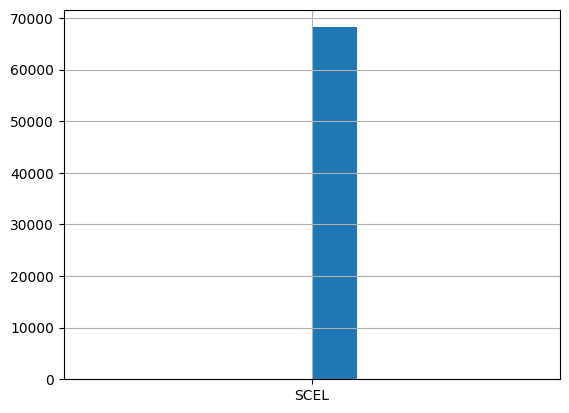

In [52]:
df['Ori-I'].hist()

Todos los vuelos salen de Santiago, Chile

### Des-I

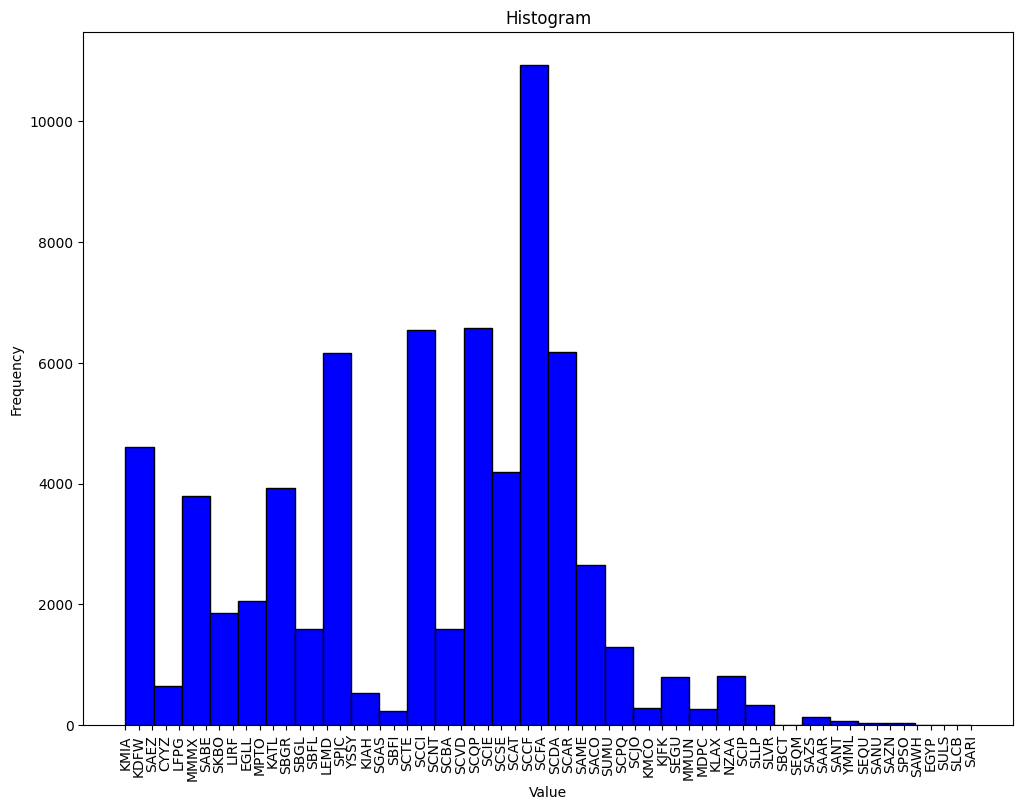

In [162]:
plt.figure(figsize=(12, 9))
plt.hist(df['Des-I'], bins=30, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.xticks(rotation=90)
plt.show()

In [36]:
top_10_destinations = df.value_counts('Des-I').reset_index().sort_values('count', ascending=False).head(10)
top_10_destinations.merge(df[['Des-I','SIGLADES']]).drop_duplicates()

,Des-I,count,SIGLADES
0,SCFA,5787,Antofagasta
2136,SCFA,5787,Calama
5787,SPJC,5270,Lima
11057,SCCF,5145,Calama
16202,SCTE,4357,Puerto Montt
16300,SCTE,4357,Temuco
17669,SCTE,4357,Punta Arenas
20559,SCIE,3995,Concepcion
20829,SCIE,3995,Temuco
24115,SCIE,3995,Puerto Montt


Top 10 destinos según el campo Des-I, tiene más SIGLASDES de lo que debería --> SIGLADES mal etiquetado quizás

### Emp-I

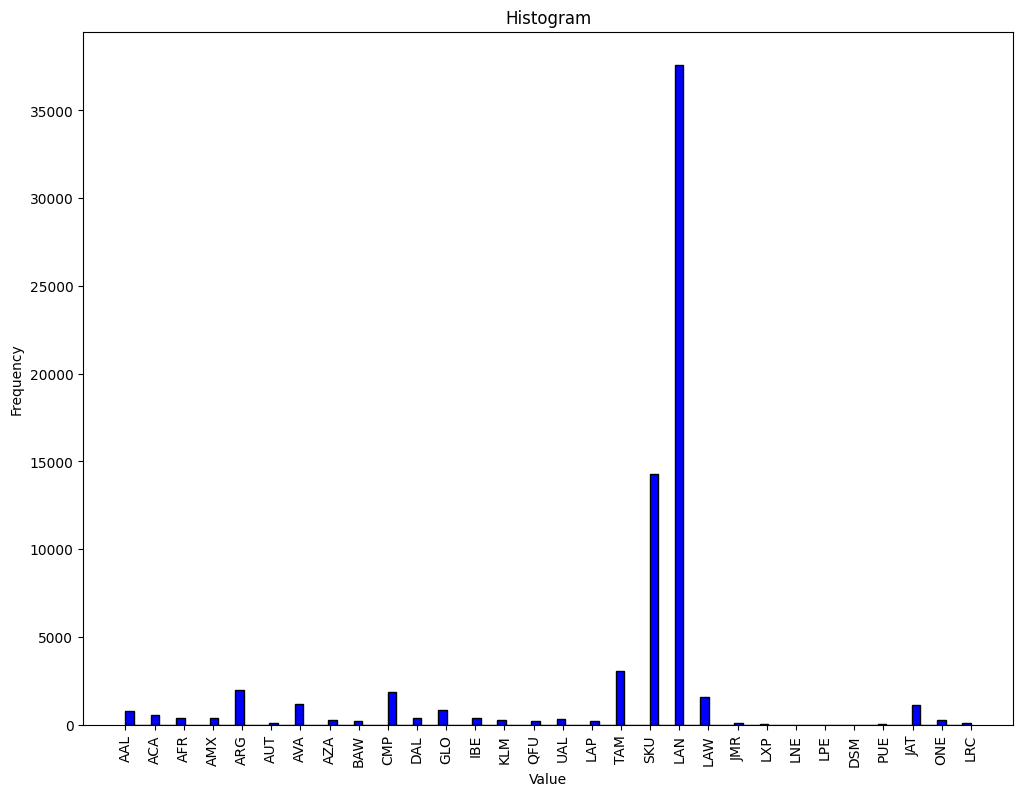

In [38]:
plt.figure(figsize=(12, 9))
plt.hist(df['Emp-I'], bins=100, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.xticks(rotation=90)
plt.show()

La mayoría de la base tiene vuelos de LAN y SKU

### Ori-O

<Axes: >

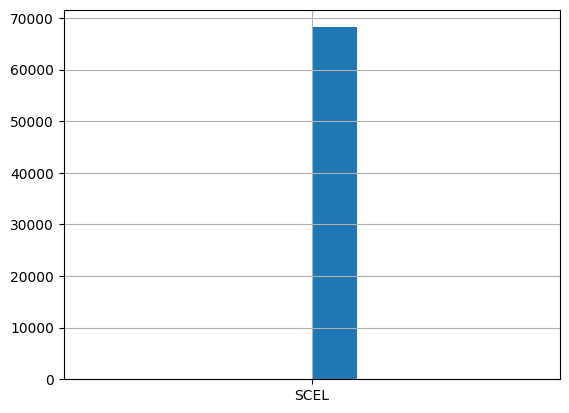

In [53]:
df['Ori-O'].hist()

### Des-O

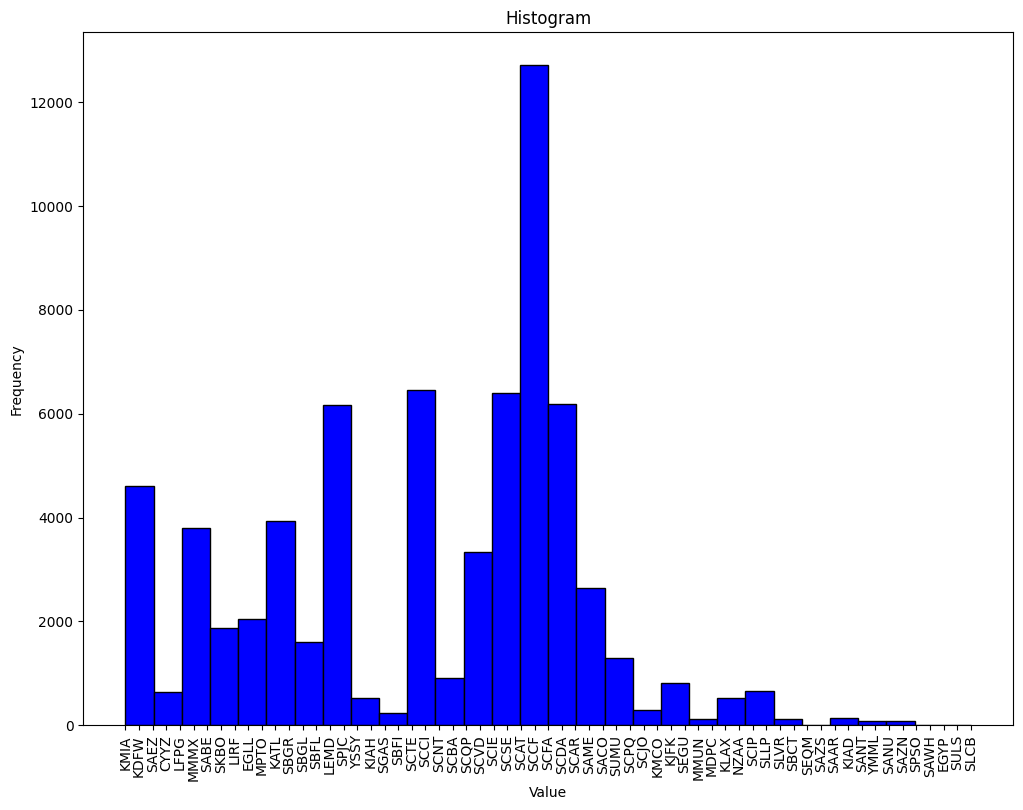

In [41]:
plt.figure(figsize=(12, 9))
plt.hist(df['Des-O'], bins=30, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.xticks(rotation=90)
plt.show()

In [42]:
top_10_destinations = df.value_counts('Des-O').reset_index().sort_values('count', ascending=False).head(10)
top_10_destinations.merge(df[['Des-O','SIGLADES']]).drop_duplicates()

,Des-O,count,SIGLADES
0,SCFA,5786,Antofagasta
5786,SPJC,5270,Lima
11056,SCCF,5146,Calama
16202,SCTE,4357,Puerto Montt
20559,SCIE,3993,Concepcion
24552,SCDA,3747,Iquique
28299,SBGR,3569,Sao Paulo
31868,SAEZ,3241,Buenos Aires
35109,SABE,3094,Buenos Aires
38203,SCQP,2589,Temuco


Ahora el cruce de Des-O con SIGLADES si da 1-1. Por lo tanto, el campo SIGLADES es referente al destino operacional

In [44]:
 df['SIGLADES'].nunique(), df['Des-O'].nunique()

(62, 63)

In [50]:
df[['Des-O','SIGLADES']].drop_duplicates().sort_values('Des-O').head(60)

,Des-O,SIGLADES
109,CYYZ,Toronto
461,EGLL,Londres
61213,EGYP,Puerto Stanley
653,KATL,Atlanta
48,KDFW,Dallas
39265,KIAD,Washington
865,KIAH,Houston
5034,KJFK,Nueva York
5183,KLAX,Los Angeles
4997,KMCO,Orlando


### Emp-O

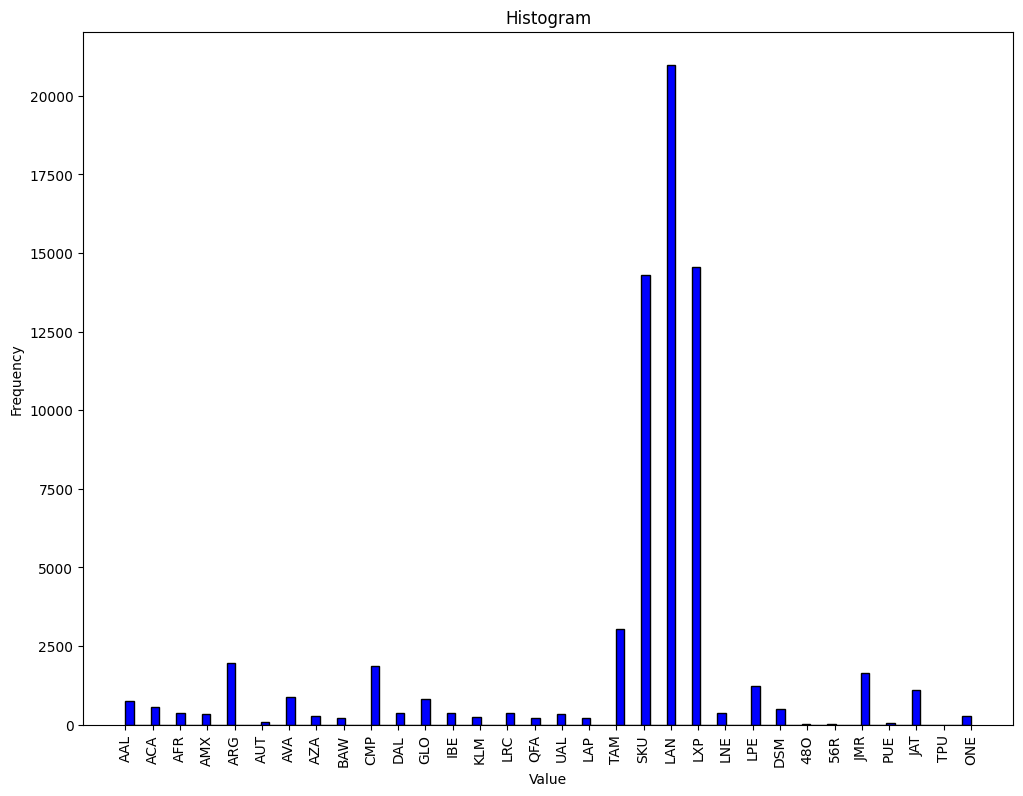

In [54]:
plt.figure(figsize=(12, 9))
plt.hist(df['Emp-O'], bins=100, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.xticks(rotation=90)
plt.show()

La mayoría de los vuelos -O corresponden a la aerolinea LAN, SKU y LXP. Desde el -I (programado) al -O (operación) aparecieron muchos vuelos de LXP.

### MES

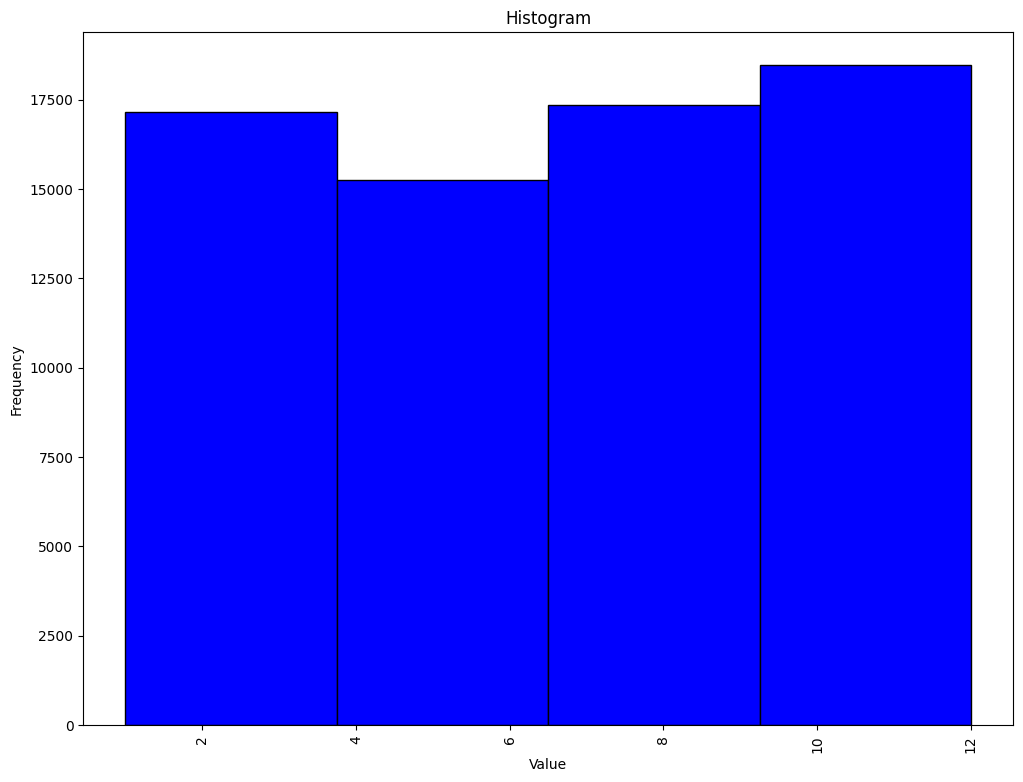

In [57]:
plt.figure(figsize=(12, 9))
plt.hist(df['MES'], bins=4, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.xticks(rotation=90)
plt.show()

Si dividimos el año en trimestres, el segundo trimestre es el que tiene una menor cantidad de vuelos (temporada baja), mientras que el que más vuelos tienes es el cuarto trimestre (temporada alta)

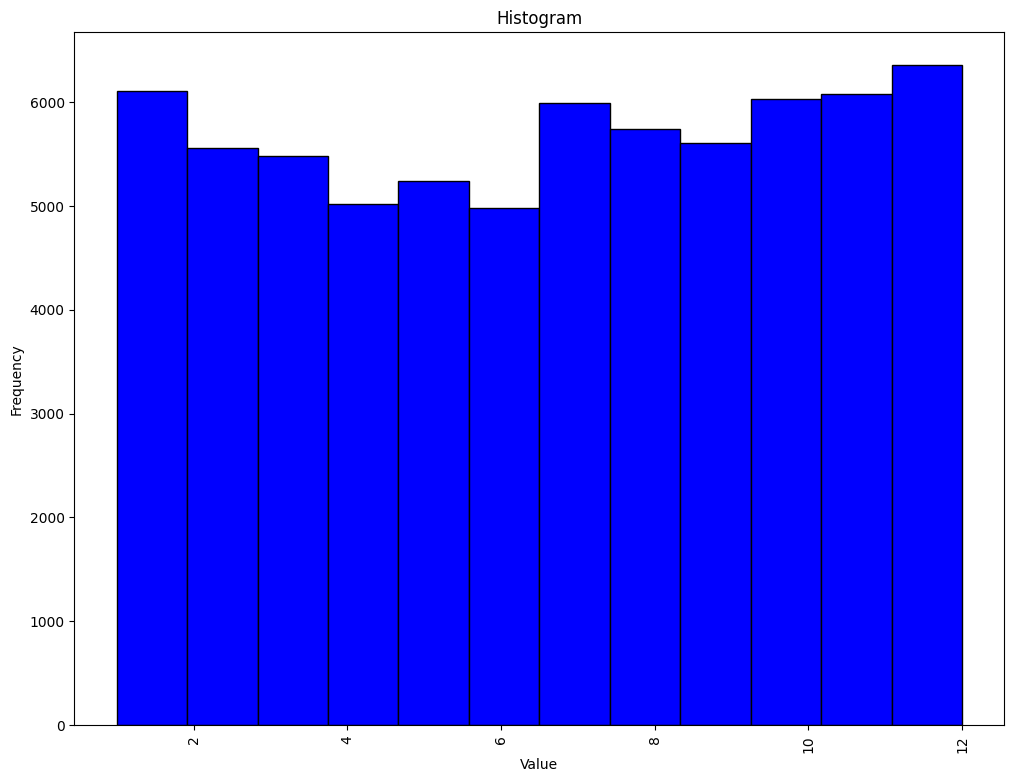

In [58]:
plt.figure(figsize=(12, 9))
plt.hist(df['MES'], bins=12, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.xticks(rotation=90)
plt.show()

Abril y junio son los meses con menos vuelos. Diciembre y enero los que tienen más vuelos.

### DIA

In [60]:
df.head(5)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


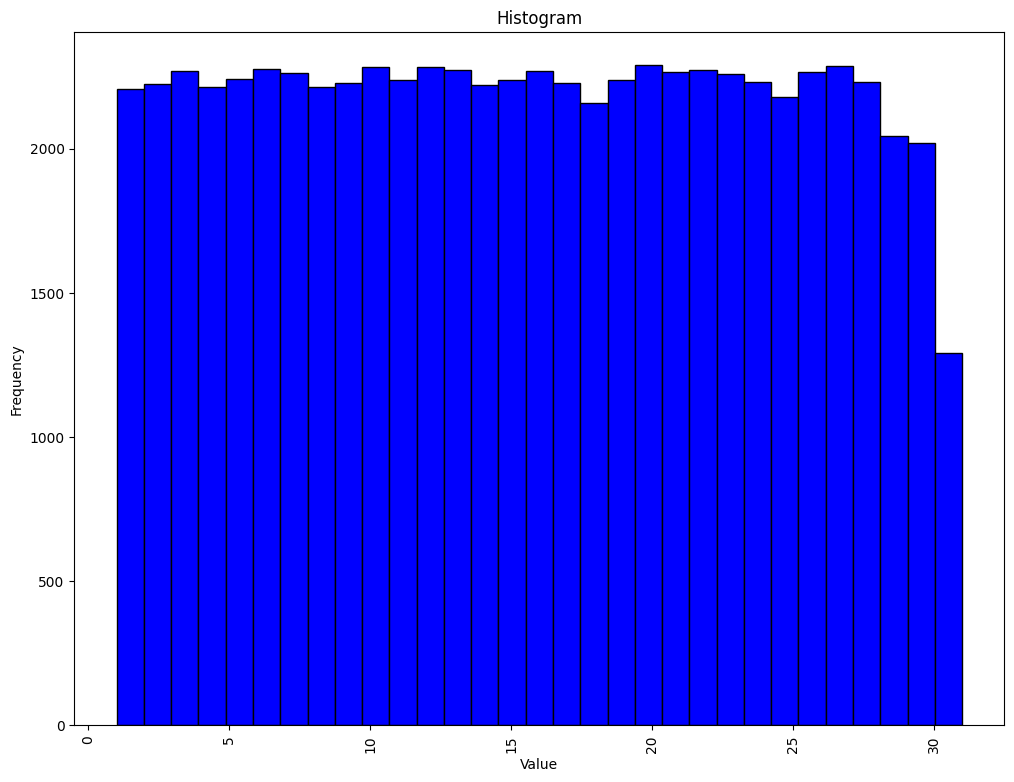

In [63]:
plt.figure(figsize=(12, 9))
plt.hist(df['DIA'], bins=31, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.xticks(rotation=90)
plt.show()

Sobre el día del mes, no parece haber algún día en el que predomine notoriamente la cantidad de vuelos por sobre los demás, salvo el día 31 que sucede porque la mitad de los meses tienen 31 días.

In [72]:
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])
df

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68201,2017-12-22 14:55:00,400,SCEL,SPJC,JAT,2017-12-22 15:41:00,400.0,SCEL,SPJC,JAT,22,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima
68202,2017-12-25 14:55:00,400,SCEL,SPJC,JAT,2017-12-25 15:11:00,400.0,SCEL,SPJC,JAT,25,12,2017,Lunes,I,JetSmart SPA,Santiago,Lima
68203,2017-12-27 14:55:00,400,SCEL,SPJC,JAT,2017-12-27 15:35:00,400.0,SCEL,SPJC,JAT,27,12,2017,Miercoles,I,JetSmart SPA,Santiago,Lima
68204,2017-12-29 14:55:00,400,SCEL,SPJC,JAT,2017-12-29 15:08:00,400.0,SCEL,SPJC,JAT,29,12,2017,Viernes,I,JetSmart SPA,Santiago,Lima


In [76]:
df['fecha_vuelo_O'] = df['Fecha-O'].apply(lambda x: x.date())
df['tiempo_vuelo_O'] = df['Fecha-O'].apply(lambda x: x.time())

In [82]:
flights_per_day = df['fecha_vuelo_O'].value_counts().reset_index()

In [90]:
flights_per_day['fecha_vuelo_O'] = pd.to_datetime(flights_per_day['fecha_vuelo_O'])

In [93]:
flights_per_day = flights_per_day.sort_values('fecha_vuelo_O')

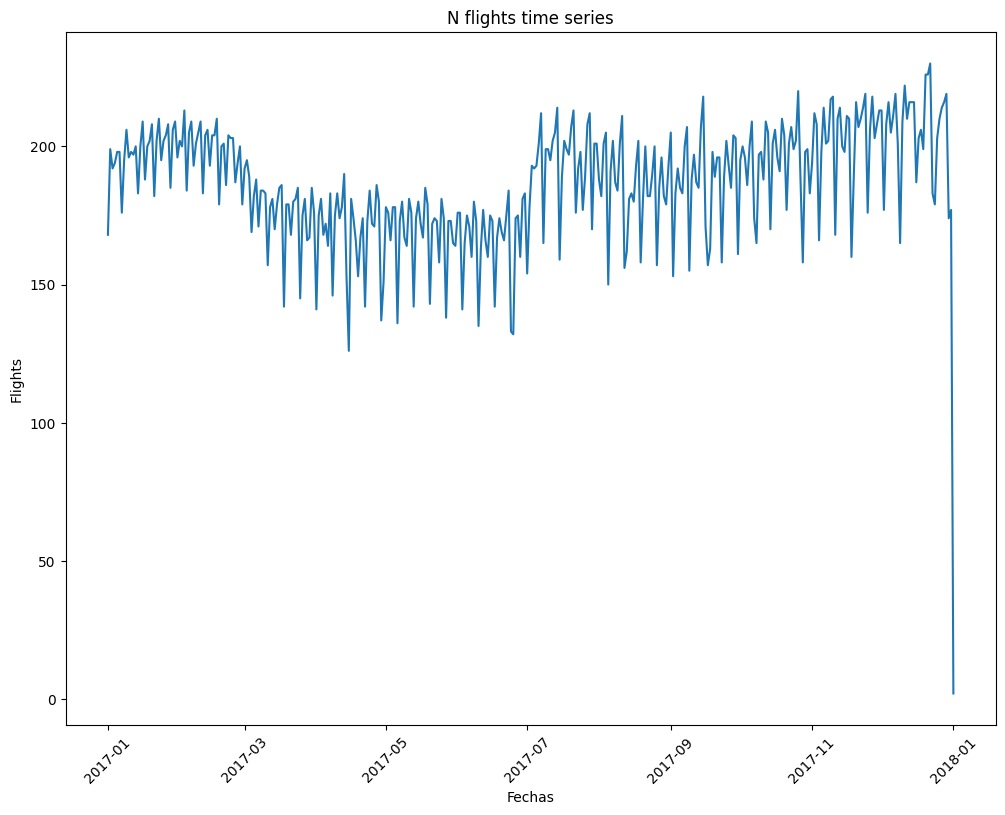

In [95]:
plt.figure(figsize=(12, 9))
plt.plot(pd.to_datetime(flights_per_day['fecha_vuelo_O']),flights_per_day['count'])
plt.xlabel('Fechas')
plt.ylabel('Flights')
plt.title('N flights time series')
plt.xticks(rotation=45)
plt.show()


Al graficar la cantidad de vuelos que se tienen de forma diaria, se puede apreciar el mismo efecto mensual (obviamente). Sin embargo, se pueden ver ciertos peaks negativos con una cierta frecuencia --> Efecto semanal, no todos los días son iguales.

### DIANOM

In [114]:
weekly_flights_total = df.value_counts('DIANOM').reset_index()
weekly_flights_total['index_day'] = np.where(
    weekly_flights_total.DIANOM == 'Lunes',
    1,
    np.where(
        weekly_flights_total.DIANOM == 'Martes',
        2,
        np.where(
            weekly_flights_total.DIANOM == 'Miercoles',
            3,
            np.where(
                weekly_flights_total.DIANOM == 'Jueves',
                4,
                np.where(
                    weekly_flights_total.DIANOM == 'Viernes',
                    5,
                    np.where(
                        weekly_flights_total.DIANOM == 'Sabado',
                        6,
                        7
                    )
                )
            )
        )
    )
)
weekly_flights_total = weekly_flights_total.sort_values('index_day')

In [115]:
weekly_flights_avg = df.groupby('DIANOM').DIA.count().reset_index()
total_weeks_per_year = df[['fecha_vuelo_O','DIANOM']].drop_duplicates().groupby('DIANOM').fecha_vuelo_O.count().reset_index()
weekly_flights_avg = weekly_flights_avg.merge(total_weeks_per_year)
weekly_flights_avg['avg_flights'] = weekly_flights_avg['DIA']/weekly_flights_avg['fecha_vuelo_O']
weekly_flights_avg['index_day'] = np.where(
    weekly_flights_avg.DIANOM == 'Lunes',
    1,
    np.where(
        weekly_flights_avg.DIANOM == 'Martes',
        2,
        np.where(
            weekly_flights_avg.DIANOM == 'Miercoles',
            3,
            np.where(
                weekly_flights_avg.DIANOM == 'Jueves',
                4,
                np.where(
                    weekly_flights_avg.DIANOM == 'Viernes',
                    5,
                    np.where(
                        weekly_flights_avg.DIANOM == 'Sabado',
                        6,
                        7
                    )
                )
            )
        )
    )
)

weekly_flights_avg = weekly_flights_avg.sort_values('index_day')

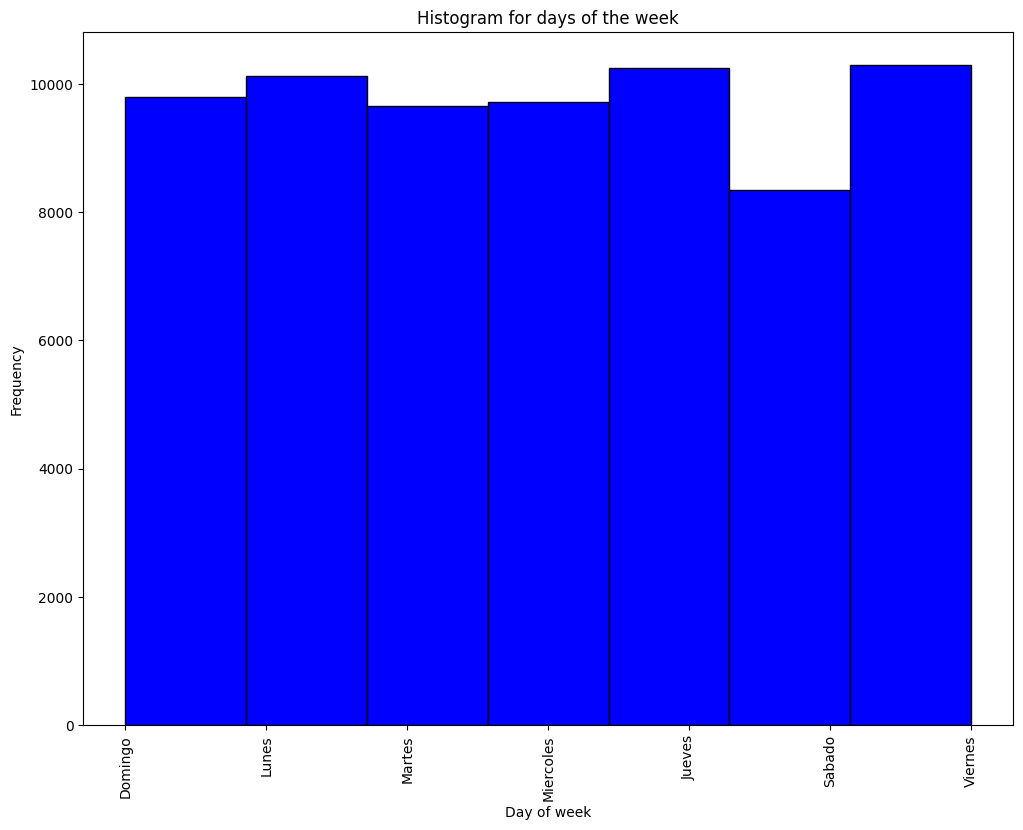

In [125]:
plt.figure(figsize=(12, 9))
plt.hist(df['DIANOM'], bins=7, color='blue', edgecolor='black')
plt.xlabel('Day of week')
plt.ylabel('Frequency')
plt.title('Histogram for days of the week')
plt.xticks(rotation=90)
plt.show()

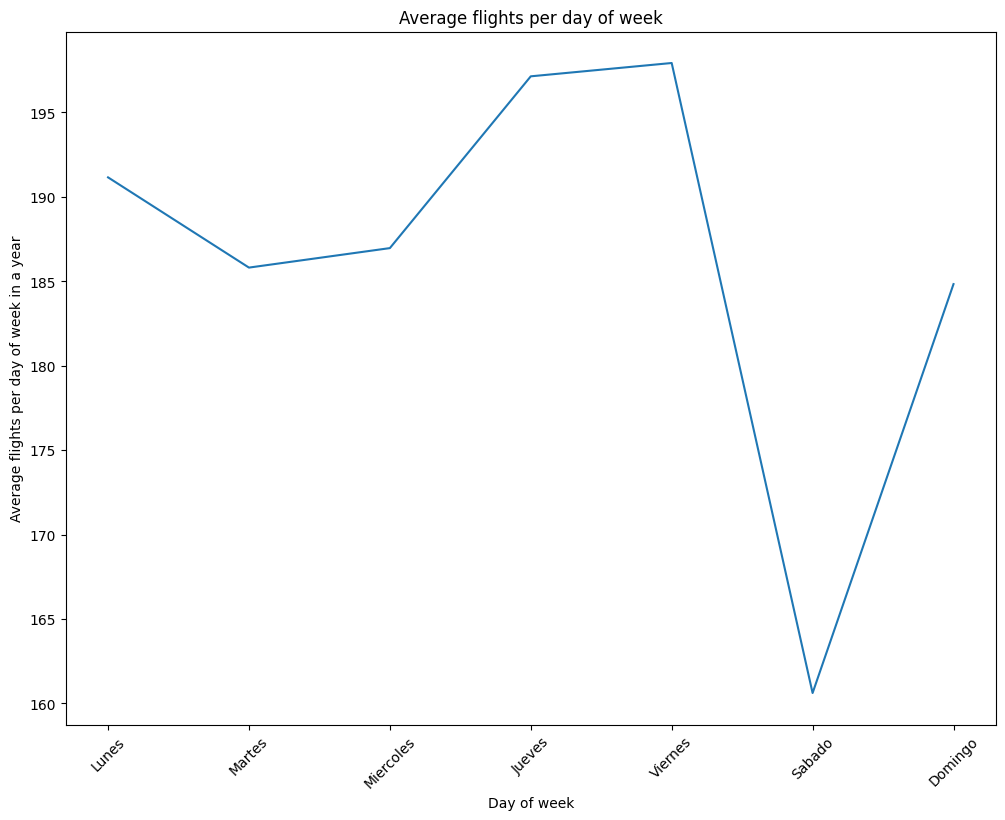

In [126]:
plt.figure(figsize=(12, 9))
plt.plot(weekly_flights_avg['DIANOM'], weekly_flights_avg['avg_flights'])
plt.xlabel('Day of week')
plt.ylabel('Average flights per day of week in a year')
plt.title('Average flights per day of week')
plt.xticks(rotation=45)
plt.show()


En los 2 gráficos mostrados podemos apreciar que tanto a nivel global, como a nivel promedio, el día sábado es el día en que menos vuelos salen, mientras que el día viernes es el día en que en promedio salen más vuelos durante el año.

### Hora

In [139]:
df['HORA'] = df['tiempo_vuelo_O'].apply(lambda x: x.hour)

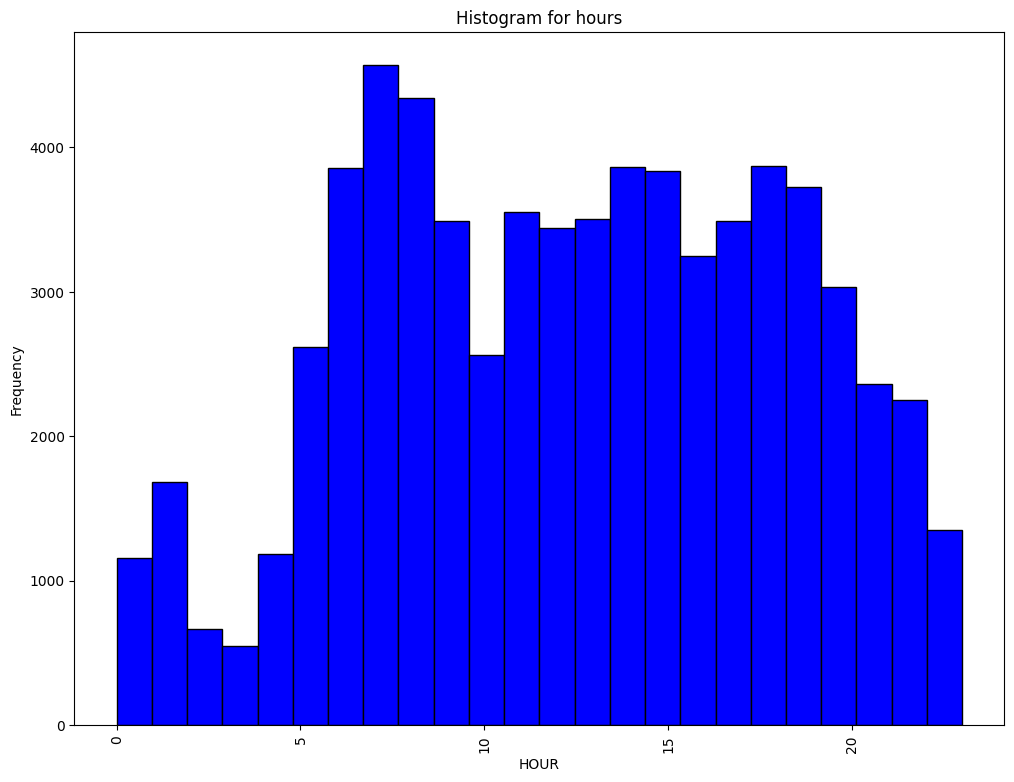

In [145]:
plt.figure(figsize=(12, 9))
plt.hist(df['HORA'], bins=24, color='blue', edgecolor='black')
plt.xlabel('HOUR')
plt.ylabel('Frequency')
plt.title('Histogram for hours')
plt.xticks(rotation=90)
plt.show()

In [156]:
hourly_flights = df.groupby('HORA').agg(distinct_count=('fecha_vuelo_O','nunique'), total=('DIA','count')).reset_index()
hourly_flights['mean_flights'] = hourly_flights['total']/hourly_flights['distinct_count']
hourly_flights

,HORA,distinct_count,total,mean_flights
0,0,333,1155,3.468468
1,1,363,1684,4.639118
2,2,314,665,2.117834
3,3,346,546,1.578035
4,4,352,1184,3.363636
5,5,364,2616,7.186813
6,6,365,3860,10.575342
7,7,365,4570,12.520548
8,8,365,4341,11.893151
9,9,365,3488,9.556164


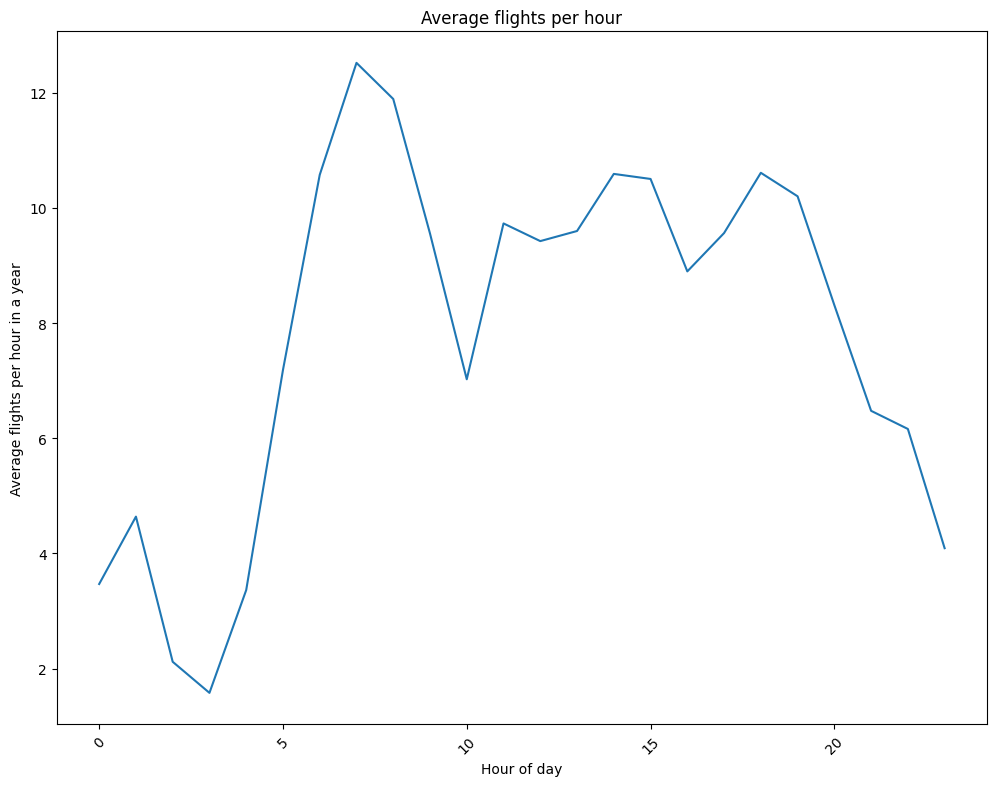

In [157]:
plt.figure(figsize=(12, 9))
plt.plot(hourly_flights['HORA'], hourly_flights['mean_flights'])
plt.xlabel('Hour of day')
plt.ylabel('Average flights per hour in a year')
plt.title('Average flights per hour')
plt.xticks(rotation=45)
plt.show()


Para el caso de las horas, tanto a nivel global como promedio la madrugada es en donde menos vuelos salen, mientras que en la mañana al rededor de las 7am es donde más vuelos salen.

### Tipo vuelo

<Axes: >

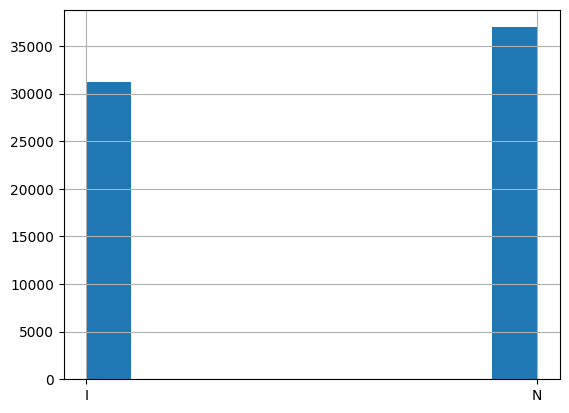

In [158]:
df.TIPOVUELO.hist()

In [159]:
df.groupby('TIPOVUELO').DIA.count()

TIPOVUELO
I    31240
N    36966
Name: DIA, dtype: int64

In [160]:
36966/(36966+31240)

0.5419757792569568

El 54% de los vuelos del 2017 fueron Nacionales

### Conclusiones sobre la distribuciones
Existen ciertas variables que son prácticamente constantes, es decir, no sirven para el entrenamiento del modelo (si en distintas condiciones se comporta de la misma forma no aporta información). Estas variables serían:
- El día del mes
- Data de origen programado
- Data de origen operacional

Por otro lado, las demás variables si tienen algunos valores que predominan. A continuación están los principales insights sobre las distribuciones:
- Hay ciertas ciudades (principalmente nacional) que son las que tienen una mayor frecuencia de destino.
- Existen ciertas aerolineas que acumulan la gran mayoría de los vuelos que salen de Santiago: LAN y SKU.
- Abril y junio son los meses con menos vuelos. Diciembre y enero los que tienen más vuelos.
- El día sábado es el día en que menos vuelos salen, mientras que el día viernes es el día en que en promedio salen más vuelos durante el año.
- La madrugada es en donde menos vuelos salen, mientras que en la mañana al rededor de las 7am es donde más vuelos salen.
- El 54% de los vuelos fueron Nacionales el 2017

## Validaciones varias

Apuntes sobre la data:
- Al parecer las features que tienen un -I son las que estaban programadas, y las features con un -O son lo que realmente sucedió
- Target: Fecha-O - Fecha-I --> Atraso (o adelanto). Acá se podría dar una cierta holgura de X minutos. Por definir.
- Vlo-I corresponde al número del vuelo. ¿La combinación de Origen-Destino-Horario hacen un número de vuelo? Validar
- Se tiene ciudad de origen y destino -O. ¿Esto quiere decir que las ciudades pueden ser distintas a lo que estaba programada? Sucede lo mismo con las aerolineas y el código del vuelo, pueden ser distintas a lo programado?
- Revisar si están bien los códigos con lo que realmente es --> validar con OPERA, SIGLAORI y SIGLADES.

In [164]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,fecha_vuelo_O,tiempo_vuelo_O,HORA
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,1,2017,Domingo,I,American Airlines,Santiago,Miami,2017-01-01,23:33:00,23
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,1,2017,Lunes,I,American Airlines,Santiago,Miami,2017-01-02,23:39:00,23
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,1,2017,Martes,I,American Airlines,Santiago,Miami,2017-01-03,23:39:00,23
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,1,2017,Miercoles,I,American Airlines,Santiago,Miami,2017-01-04,23:33:00,23
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,1,2017,Jueves,I,American Airlines,Santiago,Miami,2017-01-05,23:28:00,23


In [171]:
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])
df['fecha_vuelo_I'] = df['Fecha-I'].apply(lambda x: x.date())
df['tiempo_vuelo_I'] = df['Fecha-I'].apply(lambda x: x.time())

In [169]:
df['Vlo-I'].nunique()

750

In [180]:
df[['Vlo-I','Ori-I','Des-I', 'Emp-I']].drop_duplicates().sort_values(['Emp-I','Vlo-I'])

,Vlo-I,Ori-I,Des-I,Emp-I
0,226,SCEL,KMIA,AAL
18,912,SCEL,KMIA,AAL
48,940,SCEL,KDFW,AAL
27464,940P,SCEL,KDFW,AAL
17206,9625,SCEL,KMIA,AAL
...,...,...,...,...
50837,9851,SCEL,SBGR,TAM
33676,9955,SCEL,SBGR,TAM
33670,9956,SCEL,SPJC,TAM
865,846,SCEL,KIAH,UAL


La combinación Origen, Destino, Fecha de salida no es necesariamente un número de vuelo. Para una misma aerolinea, mismo origen y mismo destino, y mismo número de vuelo, se tienen distintos horarios de salida.

In [184]:
destinations = df[['Des-I','Des-O']].drop_duplicates()
destinations['changed_from_I_to_O'] = np.where(destinations['Des-I']==destinations['Des-O'],0,1)
destinations

,Des-I,Des-O,changed_from_I_to_O
0,KMIA,KMIA,0
48,KDFW,KDFW,0
79,SAEZ,SAEZ,0
109,CYYZ,CYYZ,0
138,LFPG,LFPG,0
...,...,...,...
62651,YSSY,YMML,1
64297,SULS,SULS,0
67599,SAEZ,SABE,1
67692,SLCB,SLCB,0


In [185]:
destinations[destinations.changed_from_I_to_O==1]

,Des-I,Des-O,changed_from_I_to_O
1397,SCTE,SCQP,1
7520,SCIE,SCQP,1
12823,SCBA,SCTE,1
16169,KJFK,KMIA,1
16937,SEGU,SABE,1
20444,SCTE,SCCI,1
24569,SCFA,SCCF,1
33166,SBGR,SBGL,1
37162,SABE,SAEZ,1
39265,KIAH,KIAD,1


Hay 16 casos en los que el Destino programado fue distinto al Destino real. ¿Por qué sucede esto?
- Emergencias aereas, vuelos deben aterrizar en otro lugar.
- Error en la data

# ME FALTA HACER LAS VALIDACIONES DE LO MISMO QUE RECIÉN PERO CON AEROLINEAS Y NUMERO DE VUELO

# ME FALTA VALIDAR SI POR LAS DESCRIPCIONES DE LAS SIGLAS CALZAN LAS SIGLAS, PARA DESTINO Y PARA AEROLINEA

## Valores nulos

In [186]:
df.isna().sum()

Fecha-I           0
Vlo-I             0
Ori-I             0
Des-I             0
Emp-I             0
Fecha-O           0
Vlo-O             1
Ori-O             0
Des-O             0
Emp-O             0
DIA               0
MES               0
AÑO               0
DIANOM            0
TIPOVUELO         0
OPERA             0
SIGLAORI          0
SIGLADES          0
fecha_vuelo_O     0
tiempo_vuelo_O    0
HORA              0
fecha_vuelo_I     0
tiempo_vuelo_I    0
dtype: int64

No se tienen valores nulos

## Target

In [187]:
# Definir 4 variables: high_season, min_diff, delay_15 (target), period_day
# Subir nuevo df como csv al git